## 0. Imports
All the repos needed in the notebook.

In [1]:
pip install joblib numpy pandas matplotlib seaborn scikit-learn scikit-optimize

Note: you may need to restart the kernel to use updated packages.


In [2]:
import joblib
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# For fine tune
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical
from types import SimpleNamespace

# For visualisation
import scipy.stats as stats

# For systems
import gc
import os

## 1. Preprocessing & Data Split

Split the 'valid_time' into date and time

In [3]:
def extract_datetime_features(df):
    df['valid_time'] = pd.to_datetime(df['valid_time']) # Transfer 'valid_time' into datetime type
    df['year'] = df['valid_time'].dt.year
    df['month'] = df['valid_time'].dt.month
    df['day'] = df['valid_time'].dt.day
    df['hour'] = df['valid_time'].dt.hour
    df["season"] = ((df["month"] % 12 + 3) // 3) + 1
    return df.drop(["id"], axis=1)

Add nearby features to strength the dataset, allowing the model to capture the continuity and spatial connection of the weather.

In [4]:
# Add historical data for the specific place, time lag is one hour. Places without last hour's data results in N/A so will need to drop N/A after applying this.
def add_lag_features(df, features, group_cols=['latitude', 'longitude'], lag=1):
    df = df.sort_values(by=group_cols + ['valid_time']).reset_index(drop=True)
    for feat in features:
        df[f'{feat}_lag{lag}'] = df.groupby(group_cols)[feat].shift(lag)
        df[f'{feat}_lag{lag}'] = df[f'{feat}_lag{lag}'].fillna(df[feat])

    return df

# Construct a 3*3 window for each spot to compute the average data for the nine neighbors.
def add_spatial_averages(df, features, lat_step=0.25, lon_step=0.25):
    avg_features = []
    for feat in features:
        df_list = []
        for dlat in [-lat_step, 0, lat_step]:
            for dlon in [-lon_step, 0, lon_step]:
                shifted = df[['latitude', 'longitude', 'valid_time', feat]].copy()
                shifted['latitude'] += dlat
                shifted['longitude'] += dlon
                shifted = shifted.rename(columns={feat: f'{feat}_shift_{dlat}_{dlon}'})
                df_list.append(shifted)
        for df_part in df_list:
            df = df.merge(df_part, on=['latitude', 'longitude', 'valid_time'], how='left')
        mean_cols = [f'{feat}_shift_{dlat}_{dlon}' for dlat in [-lat_step, 0, lat_step] for dlon in [-lon_step, 0, lon_step]]
        df[f'{feat}_spatial_mean'] = df[mean_cols].mean(axis=1)
        df = df.drop(columns=mean_cols)
        # Fill missing spatial means with original feature value
        df[f'{feat}_spatial_mean'] = df[f'{feat}_spatial_mean'].fillna(df[feat])
        avg_features.append(f'{feat}_spatial_mean')
    return df

Prepare datasets

In [5]:
standard_features = [
    'tp', 'sp', 'u10', 'v10', 'u100', 'v100', 'tcc', 'ptype',
    'year', 'month', 'day', 'hour', 'season',
    'latitude', 'longitude'
]

lag_vars = ['tp', 'sp', 'u10', 'v10']
spatial_vars = ['tp', 'sp', 'tcc']

# For consistency, define lag and spatial lag features
lag_features = [f'{var}_lag1' for var in lag_vars]
spatial_lag_features = [f'{var}_lag1_spatial_mean' for var in lag_vars]

final_features = standard_features + lag_features + spatial_vars + spatial_lag_features

# Load dataset and, split valid_time, sampling for model training.
def prepare_dataset(option='standard', path='data/train.csv'):

    df = pd.read_csv(path).copy()
    df = extract_datetime_features(df)
    df = df.sort_values(by=['latitude', 'longitude', 'valid_time']).reset_index(drop=True)

    if option == 'standard':
        df = df[standard_features + ['t2m']].dropna()
        return df
    if option == 'with_lag':
        df = add_lag_features(df, lag_vars)
        df = df[standard_features + lag_features + ['t2m']].dropna()
        return df
    if option == 'with_lag_spatial':
        df = add_lag_features(df, lag_vars)
        df = add_spatial_averages(df, spatial_vars)
        df = add_spatial_averages(df, lag_features)
        df = df[final_features + ['t2m']].dropna()
        return df
    raise ValueError("Invalid option. Choose from 'standard', 'with_lag', 'with_lag_spatial'")

## 2. Split sampled train dataset
Sampling will cut the cost of fine tuning effectively.

In [6]:
# Check if the processed dataset already exists.
if os.path.exists("df.csv"):
    df = pd.read_csv("df.csv")
    print("Loaded existing df.csv successfully!")
else:
    # Prepare dataset with nearby features
    start = time.perf_counter()

    df = prepare_dataset('with_lag_spatial')
    df.to_csv("df.csv", index=False)
    print("Saved the whole dataset with nearby features as df.csv")

    end = time.perf_counter()
    print(f"Time to process dataset: {end - start:.2f} seconds")

# Sampling for the fine-tuning
df_sample = df.sample(frac=0.1, random_state=42)

# Split train and validation set on the sample
X_sample = df_sample.drop(columns=['t2m'])
y_sample = df_sample['t2m']
X_train, X_val, y_train, y_val = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

Loaded existing df.csv successfully!


## 3. Fine tuning
Try to find a set of the best parameters for the model training using bayes search cross-validation method.

In [7]:
print("Starting fine tuning...")

state =SimpleNamespace(best_params_so_far=None)
# Load existed parameters if any.
if os.path.exists("rf_best_params.pkl"):
    rf_best_params = joblib.load("rf_best_params.pkl")
    print("Loaded existing best parameters: rf_best_params.pkl")
else:
    try:
        start = time.perf_counter()

        # Define the model
        rf = RandomForestRegressor(random_state=42, n_jobs=-1)

        # Define hyperparameters search space
        search = BayesSearchCV(
            estimator=rf,
            search_spaces={
                'n_estimators': Integer(100, 500),
                'min_samples_split': Integer(2, 20),
                'min_samples_leaf': Integer(1, 10),
                'max_depth': Integer(10, 100),
                'max_features': Categorical(['sqrt', 'log2'])
            },
            n_iter=30,  # Iteration times
            n_points=1,    # Groups of hypeparamters tested at a time
            cv=3,   # Cross-validation time
            scoring='neg_mean_squared_error',
            verbose=1,  # Extend of print details
            random_state=42,
            n_jobs=-1,
            error_score='raise'
        )

        # Define a callback function to print best score and params after each iteration
        param_names = ['n_estimators', 'max_features', 'min_samples_split', 'min_samples_leaf', 'max_depth']
        iteration_counter = {'count': 0}    # Wrapped function to count iterations

        def on_step(optim_result):
            iteration_counter['count'] += 1
            current_best_score = optim_result.fun
            current_best_params = optim_result.x
            state.best_params_so_far = optim_result.x

            print(f"==========Iteration {iteration_counter['count']}==========")
            print(f"Current Best Score (neg-MSE): {current_best_score:.6f}")
            print("Current Best Params:")
            # Add names for parameters
            for name, value in zip(param_names, current_best_params):
                print(f"  - {name}: {value}")
            print("=" * 25)
            print("\n")

        # Define Early Stopper
        class EarlyStopper:
            def __init__(self, patience=3):
                self.patience = patience
                self.best_score = None
                self.best_params = None
                self.counter = 0

            def __call__(self, optim_result):
                    current_score = optim_result.fun
                    if self.best_score is None or current_score < self.best_score:
                        self.best_score = current_score
                        self.best_params = optim_result.x
                        self.counter = 0
                    else:
                        self.counter += 1
                    if self.counter >= self.patience:
                        print(f"\nEarly stopping triggered after {self.patience} rounds without improvement!")
                        raise StopIteration()

        # Start fitting with callback
        search.fit(X_train, y_train, callback=[on_step, EarlyStopper(patience=3)])

        rf_best_params = search.best_params_    # If without early stopping.


    except StopIteration:
        print("\nEarly stopping triggered, fine tuning ended normally!")

        end = time.perf_counter()
        print(f"Tuning time: {end - start:.2f} seconds")
        print("Fine tuning finished!")

        # Save best parameters
        rf_best_params = dict(zip(param_names, state.best_params_so_far)) # Use saved intermediary to get best params
        joblib.dump(rf_best_params, "rf_best_params.pkl")
        print("Best parameters found on sample saved to rf_best_params.pkl")

    except Exception as e:
        print("Error occurred during fine tuning:", e)
        raise

Starting fine tuning...
Loaded existing best parameters: rf_best_params.pkl


### Evaluation on the validation set

In [8]:
# Evaluation Using Best Parameters
print("Loading best parameters and evaluating...")

# Load best parameters
if os.path.exists("rf_best_params.pkl"):
    rf_best_params = joblib.load("rf_best_params.pkl")
    print("Loaded existing best parameters: rf_best_params.pkl")
    print("Best Parameters:", rf_best_params)
else:
    raise FileNotFoundError("rf_best_params.pkl not found. Please run the fine-tuning section first.")

# Create a model with best parameters
rf_best_params["random_state"] = 42
rf_best_params["n_jobs"] = -1
rf_best_model = RandomForestRegressor(**rf_best_params)

# Train model on sampled train set
rf_best_model.fit(X_train, y_train)

# Predict on sampled validation set
y_val_pred = rf_best_model.predict(X_val)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
r2 = r2_score(y_val, y_val_pred)
mae = mean_absolute_error(y_val, y_val_pred)

# Save evaluation metrics
metrics_sp_val = pd.DataFrame({
    'Metric': ['RMSE', 'R²', 'MAE'],
    'Value': [rmse, r2, mae]
})

metrics_sp_val.to_csv('rf_metrics_sp_val.csv', index=False)

print("\nSampled Validation Set Evaluation Metrics:")
print(metrics_sp_val)
print("Validation evaluation metrics (sampled) saved to 'rf_metrics_sp_val.csv'")

Loading best parameters and evaluating...
Loaded existing best parameters: rf_best_params.pkl
Best Parameters: {'n_estimators': 76, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 420}

Sampled Validation Set Evaluation Metrics:
  Metric     Value
0   RMSE  0.996910
1     R²  0.958577
2    MAE  0.672443
Validation evaluation metrics (sampled) saved to 'rf_metrics_sp_val.csv'


In [9]:
# Delete sample (no need sample anymore) to release memory
del X_sample, y_sample, df_sample
gc.collect()

88

## 4. Final Model trained on the whole dataset
Apply best parameters on the model trained on the unsampled whole dataset.

In [10]:
# 13mins
# Check if split files already exist
if all(os.path.exists(file) for file in ["X_full.csv", "X_val_full.csv", "y_full.csv", "y_val_full.csv"]):
    print("Split files already exist. Skipping split.")
    print("Loading existing full dataset splits...")
    X_full = pd.read_csv("X_full.csv")
    X_val_full = pd.read_csv("X_val_full.csv")
    y_full = pd.read_csv("y_full.csv").squeeze()
    y_val_full = pd.read_csv("y_val_full.csv").squeeze()
else:
    print("Split files not found. Splitting full dataset...")
    # Features and target value
    X = df.drop(columns=['t2m'])
    y = df['t2m']
    X_full, X_val_full, y_full, y_val_full = train_test_split(X, y, test_size=0.2, random_state=42)
    X_full.to_csv("full_train_data.csv", index=False)

    # Save splits
    X_full.to_csv("X_full.csv", index=False)
    X_val_full.to_csv("X_val_full.csv", index=False)
    y_full.to_csv("y_full.csv", index=False)
    y_val_full.to_csv("y_val_full.csv", index=False)
    print("Saved: training and validation splits on full dataset")

# Model fallback
if os.path.exists("rf_final_model.pkl"):
    final_model = joblib.load("rf_final_model.pkl")
    print("Loaded final model from rf_final_model.pkl")
else:
    print("Final model not found. Constructing final model...")
    start = time.perf_counter()

    params = joblib.load("rf_best_params.pkl")
    params["n_jobs"] = -1
    params["random_state"] = 42

    final_model = RandomForestRegressor(**params)
    final_model.fit(X_full, y_full)

    end = time.perf_counter()
    print(f"Final model training time: {end - start:.2f} seconds")

    joblib.dump(final_model, 'rf_final_model.pkl', compress=3)
    print("Final model saved as 'rf_final_model.pkl'")

Split files already exist. Skipping split.
Loading existing full dataset splits...
Loaded final model from rf_final_model.pkl


## 5. Evaluation
The model is evaluated by three scores: RMSE, R2, and MAE.

In [11]:
# 2mins
# Evaluation metrics
y_pred = final_model.predict(X_full)
y_val_pred = final_model.predict(X_val_full)

train_rmse = np.sqrt(mean_squared_error(y_full, y_pred))
val_rmse = np.sqrt(mean_squared_error(y_val_full, y_val_pred))
train_r2 = r2_score(y_full, y_pred)
val_r2 = r2_score(y_val_full, y_val_pred)
train_mae = mean_absolute_error(y_full, y_pred)
val_mae = mean_absolute_error(y_val_full, y_val_pred)

# Save Evaluation Metrics
metrics_rf = pd.DataFrame({
    'Dataset': ['Train', 'Validation'],
    'RMSE': [train_rmse, val_rmse],
    'R²': [train_r2, val_r2],
    'MAE': [train_mae, val_mae]
})

print("Evaluations on Full Dataset")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Validation R²: {val_r2:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Validation MAE: {val_mae:.4f}")

metrics_rf.to_csv('rf_metrics.csv', index=False)
print("Evaluation Metrics saved to 'rf_metrics.csv'")

Evaluations on Full Dataset
Training RMSE: 0.4087
Validation RMSE: 0.5747
Training R²: 0.9930
Validation R²: 0.9862
Training MAE: 0.2568
Validation MAE: 0.3654
Evaluation Metrics saved to 'rf_metrics.csv'


### Visualisation of evaluations

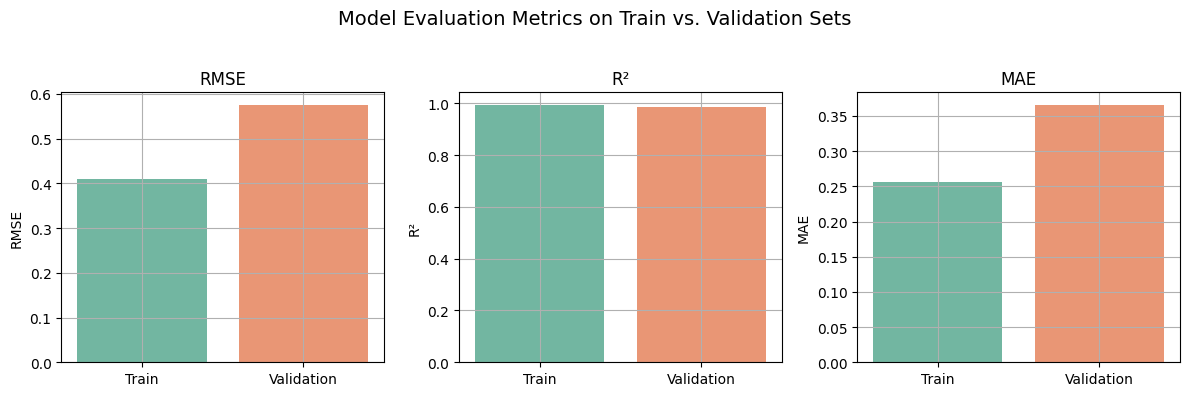

In [12]:
# Visualisation of all the evaluations
plt.figure(figsize=(12, 4))
for i, metric in enumerate(['RMSE', 'R²', 'MAE']):
    plt.subplot(1, 3, i+1)
    sns.barplot(data=metrics_rf, x='Dataset', y=metric, hue='Dataset', palette='Set2', legend=False)
    plt.title(metric)
    plt.ylabel(metric)
    plt.xlabel("")
    plt.grid(True)

plt.suptitle("Model Evaluation Metrics on Train vs. Validation Sets", fontsize=14)
plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()

The model performs well on both training and validation sets. While validation RMSE and MAE are slightly higher than training, and R² is marginally lower, the differences are small—indicating good generalization with minimal overfitting.

## 6. Predictions on the full dataset

### Saving the validation predictions
This will be later used in the final Evaluation file

In [13]:
if os.path.exists("rf_y_valid_predictions.csv"):
    print("Validation predictions file already exists. Skipping prediction.")
else:
    # Predict on the full validation dataset
    print("Start Predicting……")

    # Save predictions and true values on full validation set
    df_val_results = pd.DataFrame({
        'true_t2m': y_val_full.values,
        'predicted_t2m': y_val_pred
    })
    print("Predicting done！")

    df_val_results.to_csv('rf_y_valid_predictions.csv', index=False)
    print("Full validation results saved to 'rf_y_valid_predictions.csv'")

Validation predictions file already exists. Skipping prediction.


### Save strengthened test set for the required final predictions

In [14]:
if os.path.exists("processed_test_with_nearby_features.csv"):
    test_df = pd.read_csv("processed_test_with_nearby_features.csv")
    print("Loaded processed test set with nearby features")
else:
    # Print out the time this cell uses
    start = time.perf_counter()

    # Read and process test set
    test_df = pd.read_csv('data/test.csv').copy()
    test_df = extract_datetime_features(test_df)
    test_df = test_df.sort_values(by=['latitude', 'longitude', 'valid_time']).reset_index(drop=True)

    # Add nearby features
    test_df = add_lag_features(test_df, lag_vars)
    test_df = add_spatial_averages(test_df, spatial_vars)
    test_df = add_spatial_averages(test_df, lag_features)
    test_df = test_df[final_features].dropna()
    X_test = test_df[final_features]

    # Save to csv
    test_df.to_csv('processed_test_with_nearby_features.csv', index=False)
    end = time.perf_counter()
    print(f"Time to process test set: {end - start:.2f} seconds")
    print("Saved processed test set with nearby features to 'processed_test_with_nearby_features.csv'")

Loaded processed test set with nearby features


## 7. Result Visualisation

### Actual vs Predicted

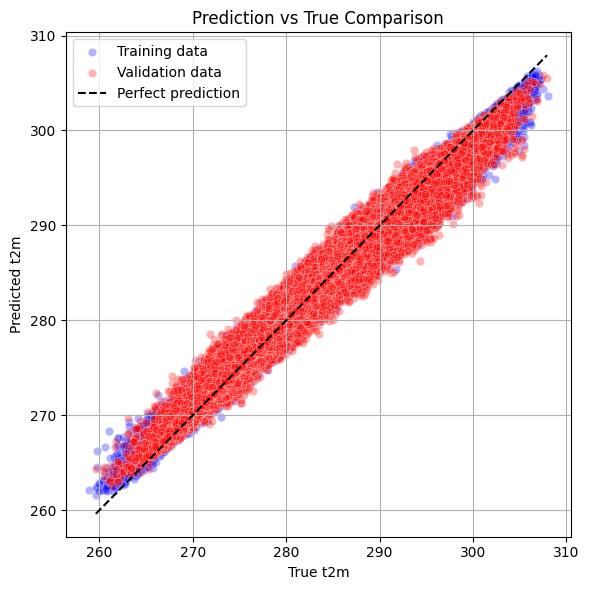

In [15]:
plt.figure(figsize=(6, 6))

# Plot training and validation in different colors
sns.scatterplot(x=y_full, y=y_pred, label='Training data', alpha=0.3, color='blue')
sns.scatterplot(x=y_val_full, y=y_val_pred, label='Validation data', alpha=0.3, color='red')

# Perfect prediction line
plt.plot([y_val_full.min(), y_val_full.max()], [y_val_full.min(), y_val_full.max()], 'k--', label='Perfect prediction')

plt.xlabel('True t2m')
plt.ylabel('Predicted t2m')
plt.title('Prediction vs True Comparison')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Most blue and red plots are close to the perfect line, which means the predictions are close to the actual values, thus model performed good.
Blue plots and red plots almost duplicated, which means model has a strong ability to transform what it learned from the train dataset to the validation set, without obvious overfitting or underfitting.
Plots shows a narrow distance on the y direction, which means residual values of predictions are small and errors are rather low.

### Residual Analysis (Validation set)

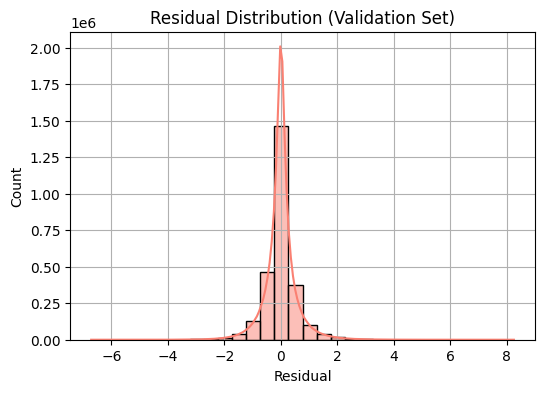

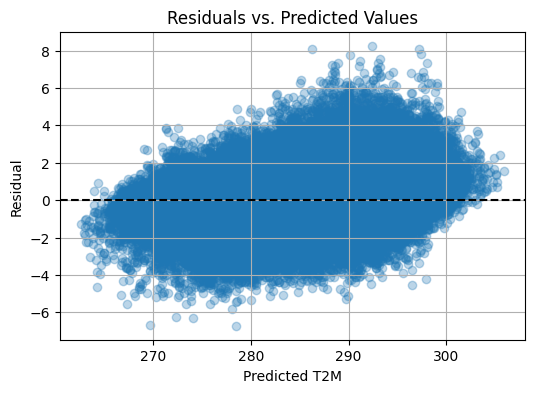

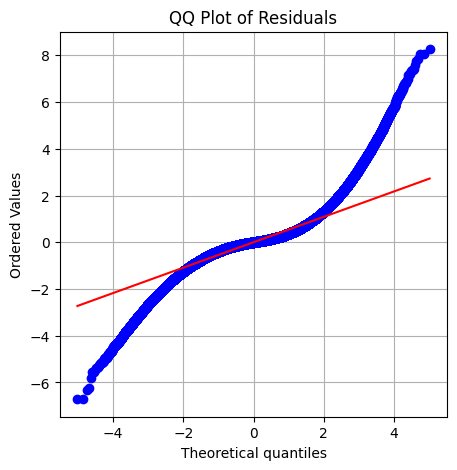

In [16]:
# Residual = true - predict
residuals = y_val_full - y_val_pred

# 1. Residual distribution
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True, bins=30, color='salmon')
plt.title("Residual Distribution (Validation Set)")
plt.xlabel("Residual")
plt.grid(True)
plt.show()

# 2. Residual vs Prediction
plt.figure(figsize=(6, 4))
plt.scatter(y_val_pred, residuals, alpha=0.3)
plt.axhline(0, color='black', linestyle='--')
plt.title("Residuals vs. Predicted Values")
plt.xlabel("Predicted T2M")
plt.ylabel("Residual")
plt.grid(True)
plt.show()

# 3. QQ plot（Normality test）
plt.figure(figsize=(5, 5))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.grid(True)
plt.show()


1. Residual Distribution (Validation Set):
The residuals are sharply centered around zero with slight tails, indicating accurate overall predictions with a few larger errors.

2. Residuals vs. Predicted Values:
Residuals are symmetrically scattered around zero, showing no major bias. Slight funnel shape hints at possible heteroscedasticity.

3. QQ Plot of Residuals:
Residuals mostly follow the normal distribution in the center but deviate at the tails, suggesting mild heavy-tailed behavior.

### Feature Importances

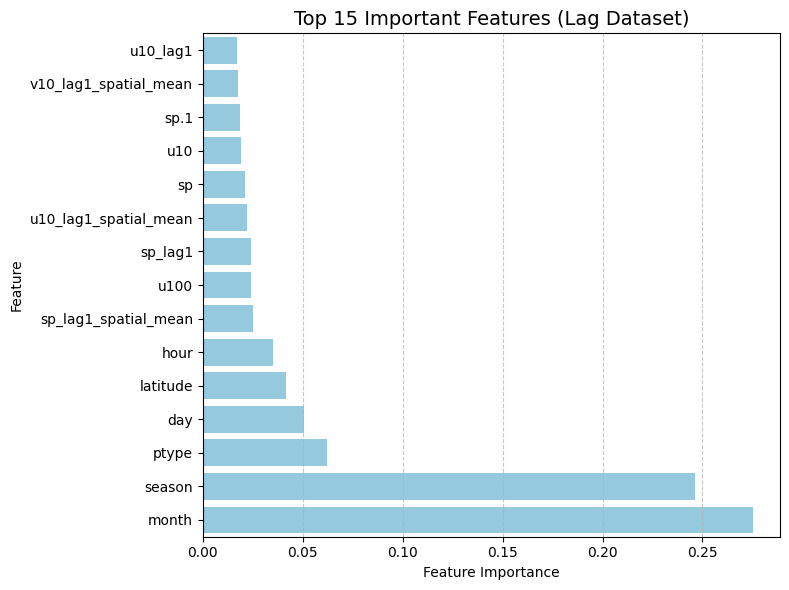

In [17]:
# Analyse which features are important, showing top 15
importances = pd.Series(final_model.feature_importances_, index=X_full.columns)
top_features = importances.sort_values(ascending=True).tail(15)

plt.figure(figsize=(8, 6))
sns.barplot(x=top_features.values, y=top_features.index, color='skyblue')
plt.title("Top 15 Important Features (Lag Dataset)", fontsize=14)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The features month and season show the highest importance, suggesting that temporal patterns play a dominant role in predicting temperature (t2m). Features like ptype, day, and latitude also contribute meaningfully, while lagged and spatial features have comparatively smaller but still notable effects.


## 8. Differences by nearby features
This part we will compare the model performances between original dataset and strengthened dataset to understand the changes brought by the nearby features.

### Standard dataset: training and prediction


In [18]:
print("Training and evaluating model on standard dataset...")

# Load standard dataset
df_std = prepare_dataset(option="standard")

# Split into train and validation set
print("Splitting standard dataset...")
X_std = df_std.drop(columns=["t2m"])
y_std = df_std["t2m"]
X_train_std, X_val_std, y_train_std, y_val_std = train_test_split(X_std, y_std, test_size=0.2, random_state=42)

Training and evaluating model on standard dataset...
Splitting standard dataset...


In [19]:
whos

Variable                    Type                     Data/Info
--------------------------------------------------------------
BayesSearchCV               ABCMeta                  <class 'skopt.searchcv.BayesSearchCV'>
Categorical                 type                     <class 'skopt.space.space.Categorical'>
Integer                     type                     <class 'skopt.space.space.Integer'>
RandomForestRegressor       ABCMeta                  <class 'sklearn.ensemble.<...>t.RandomForestRegressor'>
RandomizedSearchCV          ABCMeta                  <class 'sklearn.model_sel<...>arch.RandomizedSearchCV'>
SimpleNamespace             type                     <class 'types.SimpleNamespace'>
X_full                      DataFrame                                tp       <...>631136 rows x 26 columns]
X_std                       DataFrame                                tp       <...>288920 rows x 15 columns]
X_train                     DataFrame                                    tp   <

In [20]:
# Delete large unused variables to free memory before standard model training
del X_full, X_train, X_val
del y_full, y_train, y_val
del df, df_std, test_df
del residuals, y_pred, y_val_pred
gc.collect()
print("Cleared unused variables and collected garbage before training standard model.")

Cleared unused variables and collected garbage before training standard model.


In [21]:
# Train model on the standard dataset using the same parameters as the model trained with nearby features

if os.path.exists("rf_std_model.pkl"):
    rf_std = joblib.load("rf_std_model.pkl")
    print("Loaded standard model from rf_std_model.pkl")
else:
    print("Training model on standard dataset...")
    start = time.perf_counter()
    rf_std = RandomForestRegressor(
        n_estimators=76,
        max_features='log2',
        min_samples_split=2,
        min_samples_leaf=5,
        max_depth=420,
        random_state=42, 
        n_jobs=4)   # Use 4 cores to avoid overloading the CPU
    rf_std.fit(X_train_std, y_train_std)
    
    # Save the standard model
    joblib.dump(rf_std, 'rf_std_model.pkl', compress=3)
    print("Standard model saved as 'rf_std_model.pkl'")
    
    end = time.perf_counter()
    print(f"Standard model training time: {end - start:.2f} seconds")

Training model on standard dataset...
Standard model saved as 'rf_std_model.pkl'
Standard model training time: 605.48 seconds


In [22]:
# Predict on validation set
print("Predicting on standard validation set...")

if os.path.exists("y_val_pred_std.csv"):
    std_pred_df = pd.read_csv("y_val_pred_std.csv")
    print("Standard validation prediction file already exists. Skipping prediction.")
else:
    # Predict on the full validation dataset
    start = time.perf_counter()
    y_pred_std = rf_std.predict(X_val_std)

    # Save prediction result
    std_pred_df = pd.DataFrame({
        "y_true": y_val_std,
        "y_pred": y_pred_std
    })
    std_pred_df.to_csv("y_val_pred_std.csv", index=False)
    end = time.perf_counter()
    print(f"Standard model prediction time: {end - start:.2f} seconds")
    print("Standard model predictions saved to 'y_val_pred_std.csv'")


Predicting on standard validation set...
Standard validation prediction file already exists. Skipping prediction.


### Analysis and visualisation

Comparing standard vs. lag+nearby feature model predictions...

Comparison of model performance:
                RMSE        R²       MAE
Standard    0.495517  0.989769  0.319497
Lag+Nearby  0.574723  0.986237  0.365362


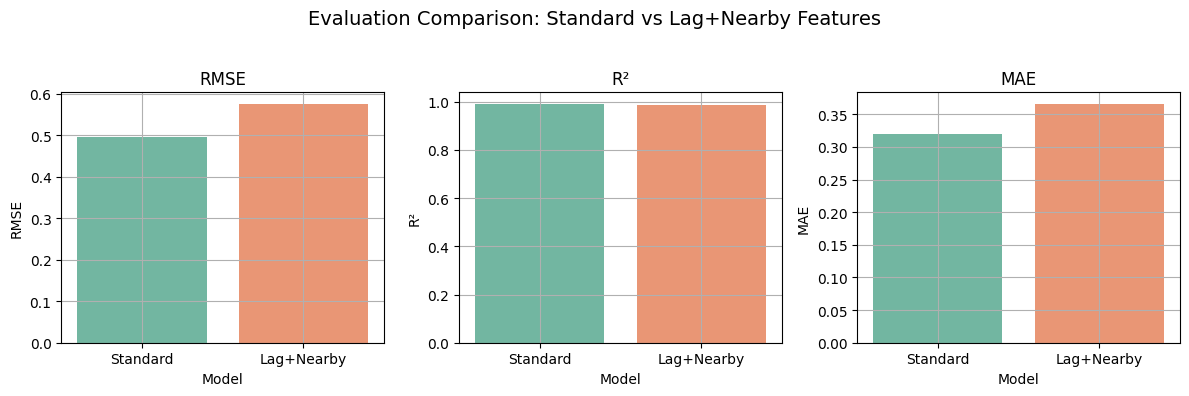

In [23]:
print("Comparing standard vs. lag+nearby feature model predictions...")

# Load prediction results
std_df = pd.read_csv("y_val_pred_std.csv")
lag_df = pd.read_csv("rf_y_valid_predictions.csv")

# Define evaluation metrics
metrics = {
    "RMSE": lambda y, yhat: mean_squared_error(y, yhat) ** 0.5,
    "R²": r2_score,
    "MAE": mean_absolute_error
}

# Compute metrics for both models
comp_results = pd.DataFrame({
    metric: [
        func(std_df["y_true"], std_df["y_pred"]),
        func(lag_df["true_t2m"], lag_df["predicted_t2m"])
    ]
    for metric, func in metrics.items()
}, index=["Standard", "Lag+Nearby"])

print("\nComparison of model performance:")
print(comp_results)

# Reshape to long format for hue
comp_long = comp_results.reset_index().melt(id_vars='index', var_name='Metric', value_name='Value')
comp_long.rename(columns={'index': 'Model'}, inplace=True)

# Visualise comparison
plt.figure(figsize=(12, 4))
for i, metric in enumerate(comp_long["Metric"].unique()):
    plt.subplot(1, 3, i+1)
    sns.barplot(data=comp_long[comp_long["Metric"]== metric],
                x="Model", y="Value", palette="Set2", hue="Model", legend=False)
    plt.title(metric)
    plt.grid(True)
    plt.ylabel(metric)

plt.suptitle("Evaluation Comparison: Standard vs Lag+Nearby Features", fontsize=14)
plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()


Although this project incorporated various enhanced features such as temporal lags and spatially nearby information, the final results suggest that these nearby features did not consistently improve model performance. One possible explanation is the presence of multicollinearity, where certain features are highly correlated with one another. This can reduce the model’s ability to distinguish the importance of individual predictors and may introduce noise that weakens generalization.

Future work should therefore place more emphasis on feature engineering, including techniques such as correlation analysis or Variance Inflation Factor (VIF) to detect and remove redundant features. Additionally, dimensionality reduction or regularization methods could be explored to enhance the robustness and predictive accuracy of the model.